<a href="https://colab.research.google.com/github/uncertainity/Sentiment-Analysis-Using-BERT/blob/main/Bert_sentiment_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install -qq transformers

     |████████████████████████████████| 4.0 MB 5.2 MB/s 
     |████████████████████████████████| 6.5 MB 38.3 MB/s 
     |████████████████████████████████| 77 kB 6.8 MB/s 
     |████████████████████████████████| 596 kB 23.0 MB/s 
     |████████████████████████████████| 895 kB 43.4 MB/s 


In [3]:
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch

import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap

from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [4]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [5]:
df = pd.read_csv("/content/drive/MyDrive/reviews.csv")
df.head()

,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,sortOrder,appId
0,Andrew Thomas,https://lh3.googleusercontent.com/a-/AOh14GiHd...,Update: After getting a response from the deve...,1,21,4.17.0.3,2020-04-05 22:25:57,"According to our TOS, and the term you have ag...",2020-04-05 15:10:24,most_relevant,com.anydo
1,Craig Haines,https://lh3.googleusercontent.com/-hoe0kwSJgPQ...,Used it for a fair amount of time without any ...,1,11,4.17.0.3,2020-04-04 13:40:01,It sounds like you logged in with a different ...,2020-04-05 15:11:35,most_relevant,com.anydo
2,steven adkins,https://lh3.googleusercontent.com/a-/AOh14GiXw...,Your app sucks now!!!!! Used to be good but no...,1,17,4.17.0.3,2020-04-01 16:18:13,This sounds odd! We are not aware of any issue...,2020-04-02 16:05:56,most_relevant,com.anydo
3,Lars Panzerbjørn,https://lh3.googleusercontent.com/a-/AOh14Gg-h...,"It seems OK, but very basic. Recurring tasks n...",1,192,4.17.0.2,2020-03-12 08:17:34,We do offer this option as part of the Advance...,2020-03-15 06:20:13,most_relevant,com.anydo
4,Scott Prewitt,https://lh3.googleusercontent.com/-K-X1-YsVd6U...,Absolutely worthless. This app runs a prohibit...,1,42,4.17.0.2,2020-03-14 17:41:01,We're sorry you feel this way! 90% of the app ...,2020-03-15 23:45:51,most_relevant,com.anydo


In [6]:
print("Shape of dataframe:",df.shape)


Shape of dataframe: (15746, 11)


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15746 entries, 0 to 15745
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   userName              15746 non-null  object
 1   userImage             15746 non-null  object
 2   content               15746 non-null  object
 3   score                 15746 non-null  int64 
 4   thumbsUpCount         15746 non-null  int64 
 5   reviewCreatedVersion  13533 non-null  object
 6   at                    15746 non-null  object
 7   replyContent          7367 non-null   object
 8   repliedAt             7367 non-null   object
 9   sortOrder             15746 non-null  object
 10  appId                 15746 non-null  object
dtypes: int64(2), object(9)
memory usage: 1.3+ MB


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 0, 'review score')

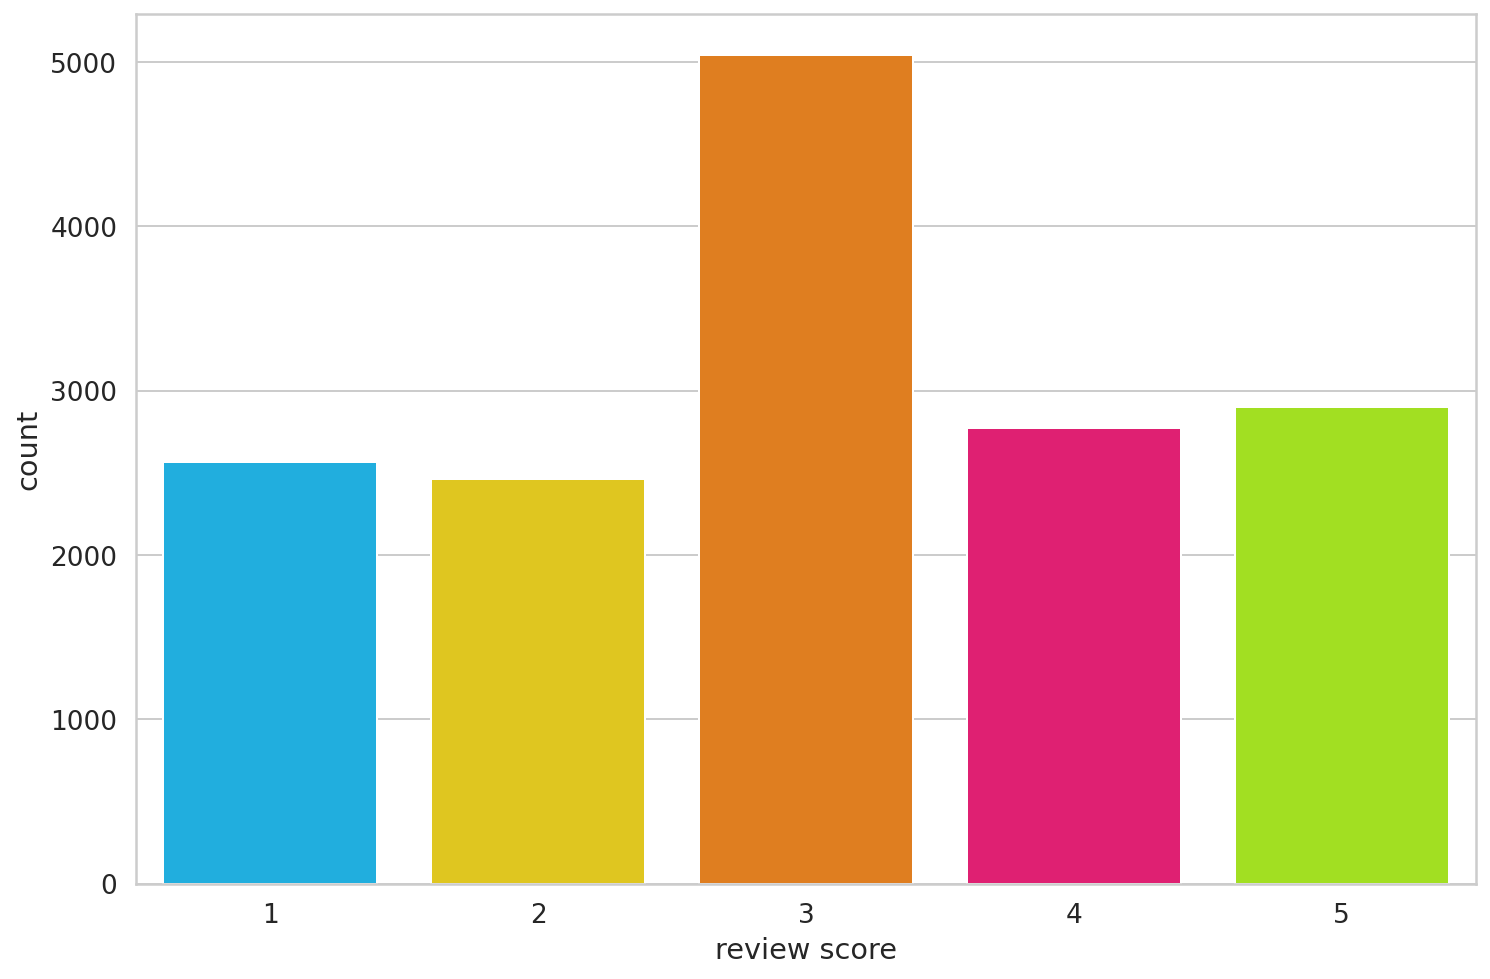

In [8]:
sns.countplot(df.score)
plt.xlabel("review score")

Changing the scores (1-5) to sentiments:
0 --> Negative // 1 --> Neutral // 2 --> Positive

In [9]:
def to_Sentiment(x):
    if x <= 2:
        return 0
    elif x == 3:
        return 1
    else:
        return 2

df["sentiment"] = df["score"].apply(to_Sentiment)

In [10]:
df.head()

,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,sortOrder,appId,sentiment
0,Andrew Thomas,https://lh3.googleusercontent.com/a-/AOh14GiHd...,Update: After getting a response from the deve...,1,21,4.17.0.3,2020-04-05 22:25:57,"According to our TOS, and the term you have ag...",2020-04-05 15:10:24,most_relevant,com.anydo,0
1,Craig Haines,https://lh3.googleusercontent.com/-hoe0kwSJgPQ...,Used it for a fair amount of time without any ...,1,11,4.17.0.3,2020-04-04 13:40:01,It sounds like you logged in with a different ...,2020-04-05 15:11:35,most_relevant,com.anydo,0
2,steven adkins,https://lh3.googleusercontent.com/a-/AOh14GiXw...,Your app sucks now!!!!! Used to be good but no...,1,17,4.17.0.3,2020-04-01 16:18:13,This sounds odd! We are not aware of any issue...,2020-04-02 16:05:56,most_relevant,com.anydo,0
3,Lars Panzerbjørn,https://lh3.googleusercontent.com/a-/AOh14Gg-h...,"It seems OK, but very basic. Recurring tasks n...",1,192,4.17.0.2,2020-03-12 08:17:34,We do offer this option as part of the Advance...,2020-03-15 06:20:13,most_relevant,com.anydo,0
4,Scott Prewitt,https://lh3.googleusercontent.com/-K-X1-YsVd6U...,Absolutely worthless. This app runs a prohibit...,1,42,4.17.0.2,2020-03-14 17:41:01,We're sorry you feel this way! 90% of the app ...,2020-03-15 23:45:51,most_relevant,com.anydo,0


In [11]:
class_names = ["negative","neutral","positive"]

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


[Text(0, 0, 'negative'), Text(0, 0, 'neutral'), Text(0, 0, 'positive')]

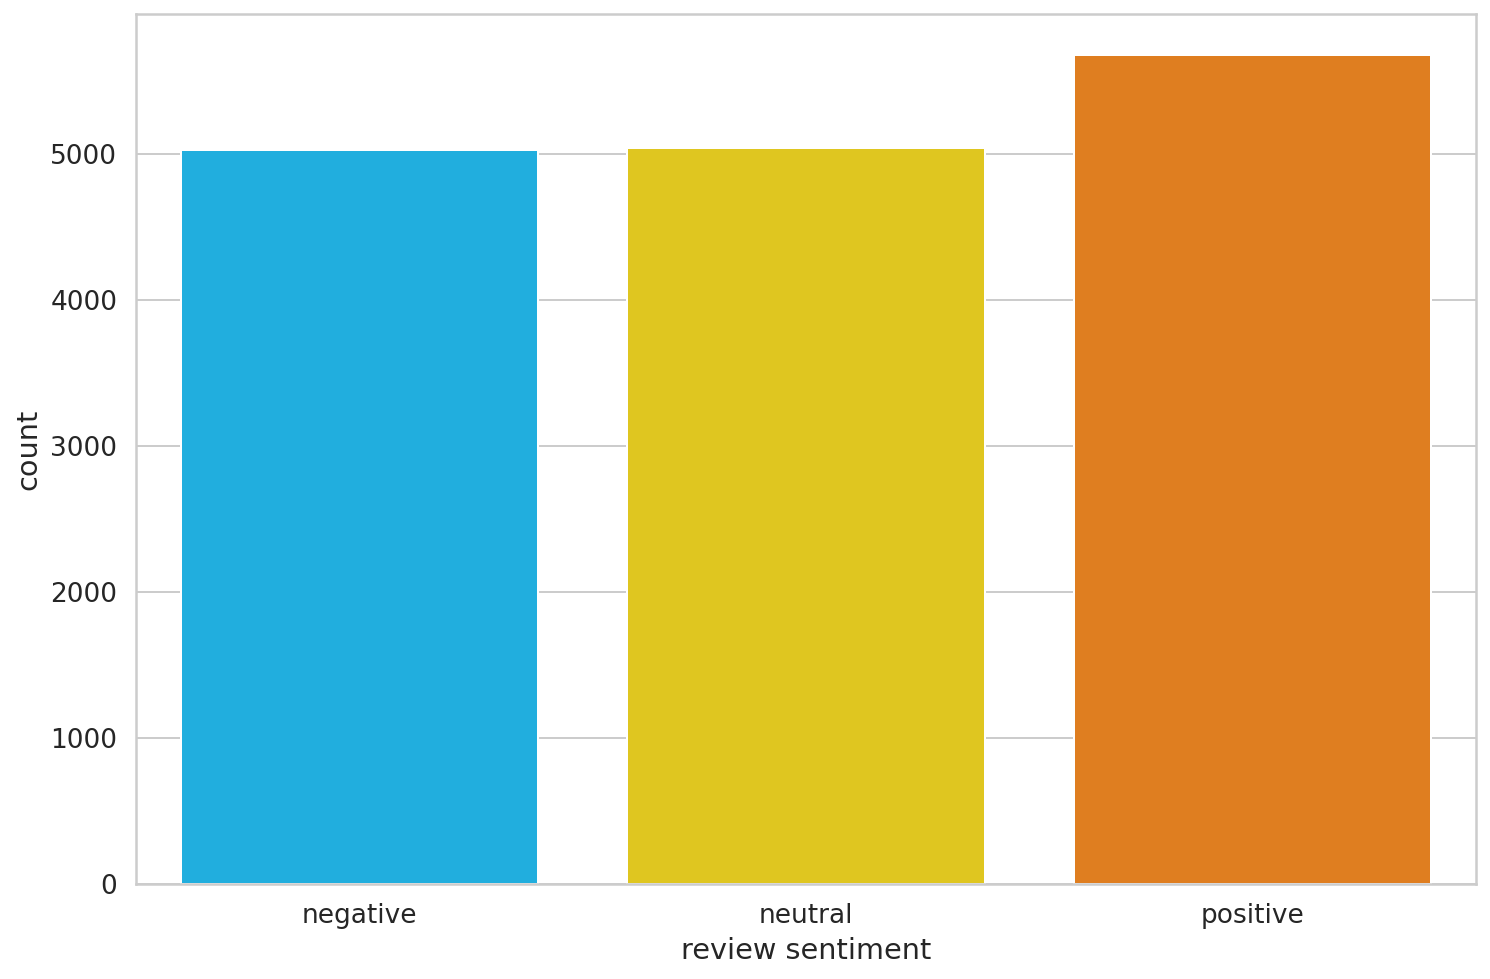

In [12]:
ax = sns.countplot(df["sentiment"])
plt.xlabel("review sentiment")
ax.set_xticklabels(class_names)

In [13]:
# Downloading the pre trained bert #
PRE_TRAINED_MODEL_NAME = "bert-base-cased"
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

Downloading:   0%|          | 0.00/208k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [14]:
sample_txt = "When was I last outside? I am stuck as home for 2 weeks"
tokens = tokenizer.tokenize(sample_txt)
token_ids = tokenizer.convert_tokens_to_ids(tokens)

print(f'sentence: {sample_txt}')
print(f'    Tokens: {tokens}')
print(f'    TOken IDS: {token_ids}')

sentence: When was I last outside? I am stuck as home for 2 weeks
    Tokens: ['When', 'was', 'I', 'last', 'outside', '?', 'I', 'am', 'stuck', 'as', 'home', 'for', '2', 'weeks']
    TOken IDS: [1332, 1108, 146, 1314, 1796, 136, 146, 1821, 5342, 1112, 1313, 1111, 123, 2277]


In [15]:
# Trying to understand how the tokenizer id works #
print(tokenizer.sep_token,tokenizer.sep_token_id)
print(tokenizer.cls_token,tokenizer.cls_token_id)
print(tokenizer.pad_token,tokenizer.pad_token_id)
print(tokenizer.unk_token,tokenizer.unk_token_id)

[SEP] 102
[CLS] 101
[PAD] 0
[UNK] 100


In [16]:
encoding = tokenizer.encode_plus(sample_txt,max_length = 32, add_special_tokens = True,padding = "max_length", truncation = True,\
                                 return_token_type_ids = True,return_attention_mask = True,return_tensors = "pt")
encoding.keys()

dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])

In [17]:
# Cheking the encoding length is 32 #
print("Length of the plus encoding:",len(encoding["input_ids"][0]))
print(type(encoding))
encoding["input_ids"][0]

Length of the plus encoding: 32
<class 'transformers.tokenization_utils_base.BatchEncoding'>


tensor([ 101, 1332, 1108,  146, 1314, 1796,  136,  146, 1821, 5342, 1112, 1313,
        1111,  123, 2277,  102,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0])

In [18]:
print(len(encoding["attention_mask"][0]))
encoding["attention_mask"]

32


tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0]])

In [19]:
tokenizer.convert_ids_to_tokens(encoding["input_ids"][0])

['[CLS]',
 'When',
 'was',
 'I',
 'last',
 'outside',
 '?',
 'I',
 'am',
 'stuck',
 'as',
 'home',
 'for',
 '2',
 'weeks',
 '[SEP]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]']

In [20]:
token_lens = []
token_ids = []
for txt in df.content:
    tokens = tokenizer.encode(txt,max_length = 512)
    token_ids.append(tokens)
    token_lens.append(len(tokens))   

print("Total text:",len(token_lens))
print("----------")
print("A sample of the text")
print("----------")
random_samples = np.random.choice(len(token_lens),5)
for sample_no in random_samples:
    print("------------")
    print("Original Text:")
    print(df.loc[sample_no]["content"])
    print("Tokenized Text:")
    print(token_ids[sample_no])
    print("------------")

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Total text: 15746
----------
A sample of the text
----------
------------
Original Text:
Decent app but repeatedly asking me to pay a monthly subscription for a fancy to-do list is completely unacceptable. Take no for an answer.
Tokenized Text:
[101, 13063, 3452, 12647, 1133, 8038, 4107, 1143, 1106, 2653, 170, 7868, 16759, 1111, 170, 13305, 1106, 118, 1202, 2190, 1110, 2423, 24726, 119, 5055, 1185, 1111, 1126, 2590, 119, 102]
------------
------------
Original Text:
Very helpful and detailed app...love it!
Tokenized Text:
[101, 6424, 14739, 1105, 6448, 12647, 119, 119, 119, 1567, 1122, 106, 102]
------------
------------
Original Text:
The app keeps stopping repeatedly. It would be helpful if the same is resolved.
Tokenized Text:
[101, 1109, 12647, 7634, 7202, 8038, 119, 1135, 1156, 1129, 14739, 1191, 1103, 1269, 1110, 10456, 119, 102]
------------
------------
Original Text:
Do not download this app. There are Ads everything you use i (as of Feb 26, 2020), despite what the developer s

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 0, 'Token Counts')

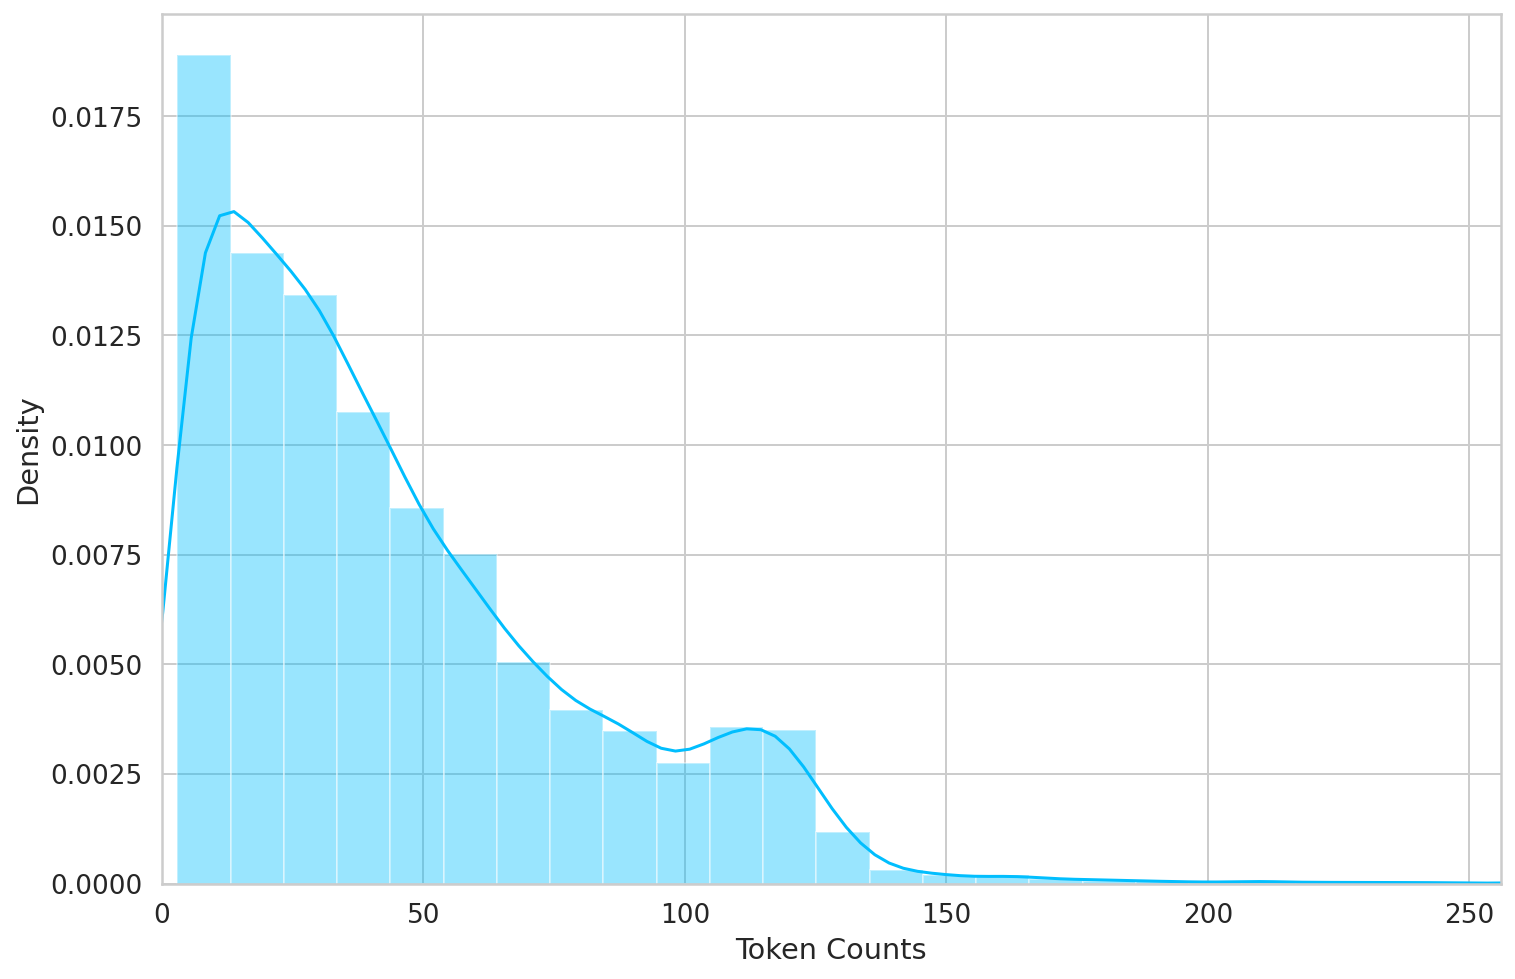

In [21]:
sns.distplot(token_lens)
plt.xlim([0,256])
plt.xlabel("Token Counts")

In [22]:
MAX_LEN = 160
class GRPReviewDataset(Dataset):
    
    def __init__(self,reviews,targets,tokenizer,max_len):
        self.reviews = reviews
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_len = max_len
    
    def __len__(self):
        return len(self.reviews)
    
    def __getitem__(self,item):
        review = str(self.reviews[item])
        target = self.targets[item]
        encoding = self.tokenizer.encode_plus(review,add_special_tokens = True,max_length = self.max_len,padding = "max_length",truncation = True,\
                                              return_token_type_ids = False,return_attention_mask = True,return_tensors = "pt")
        return {
                "review_text":review,
                "input_ids":encoding["input_ids"].flatten(),
                "attention_mask":encoding["attention_mask"].flatten(),
                "targets":torch.tensor(target,dtype = torch.long)
        }

In [23]:
df_train,df_test = train_test_split(df,test_size = 0.1,random_state = RANDOM_SEED)
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state= RANDOM_SEED)

In [24]:
print(df_train.shape,df_val.shape,df_test.shape)

(14171, 12) (787, 12) (788, 12)


In [25]:
def create_data_loader(df,tokenizer,max_len,batch_size):
    ds = GRPReviewDataset(reviews = df.content.to_numpy(),targets = df.sentiment.to_numpy(),tokenizer = tokenizer,max_len = max_len)
    return DataLoader(ds,batch_size = batch_size,num_workers = 4)


In [26]:
BATCH_SIZE = 16
train_data_loader = create_data_loader(df_train,tokenizer,MAX_LEN,BATCH_SIZE)
test_data_loader = create_data_loader(df_test,tokenizer,MAX_LEN,BATCH_SIZE)
val_data_loader = create_data_loader(df_val,tokenizer,MAX_LEN,BATCH_SIZE)


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [27]:
data = next(iter(train_data_loader))
data.keys()
## Each row is an tokenized text ##
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


torch.Size([16, 160])
torch.Size([16, 160])
torch.Size([16])


In [28]:
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
last_hidden_state,pooled_output = bert_model(input_ids = encoding["input_ids"],attention_mask = encoding["attention_mask"])

Downloading:   0%|          | 0.00/416M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [29]:
bert_model.config.hidden_size

768

In [30]:
class SentimentClassifier(nn.Module):
    def __init__(self,n_classes):
        super(SentimentClassifier,self).__init__()
        self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
        self.drop = nn.Dropout(p = 0.3)
        self.out = nn.Linear(self.bert.config.hidden_size,n_classes)
        
    def forward(self,input_ids,attention_mask):
        _,pooled_output = self.bert(input_ids = input_ids,attention_mask = attention_mask,return_dict = False)
        #print("Dimension of the pooled output = ",pooled_output.shape)
        output = self.drop(pooled_output)
        return self.out(output)
    

In [31]:
model = SentimentClassifier(len(class_names))
model = model.to(device)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [32]:
input_ids = data["input_ids"].to(device)
attention_mask = data["attention_mask"].to(device)
print(input_ids.shape)
print(attention_mask.shape)

torch.Size([16, 160])
torch.Size([16, 160])


In [33]:
EPOCHS = 10
optimizer = AdamW(model.parameters(),lr = 2e-5,correct_bias = False)
total_steps = len(train_data_loader)*EPOCHS
scheduler = get_linear_schedule_with_warmup(optimizer,num_warmup_steps = 0,num_training_steps = total_steps)
loss_fn = nn.CrossEntropyLoss().to(device)

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


In [34]:
def train_epoch(model,data_loader,loss_fn,optimizer,device,scheduler,n_examples):
    model = model.train()
    losses = []
    correct_predictions = 0
    for d in data_loader:
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        outputs = model(input_ids,attention_mask)
        targets = d["targets"].to(device)
        _,preds = torch.max(outputs,dim = 1)
        loss = loss_fn(outputs,targets)
        correct_predictions += torch.sum(preds == targets)
        losses.append(loss.item())
        
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(),max_norm = 1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()
    return correct_predictions.double()/n_examples,np.mean(losses)

In [35]:
def eval_model(model,data_loader,loss_fn,device,n_examples):
    model = model.eval()
    losses = []
    correct_predictions = 0
    print(n_examples)
    with torch.no_grad():
        for d in data_loader:
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)
            outputs = model(input_ids = input_ids,attention_mask = attention_mask)
            _,preds = torch.max(outputs,dim = 1)
            loss = loss_fn(outputs,targets)
            correct_predictions += torch.sum(preds == targets)
            losses.append(loss.item())
    return correct_predictions.double()/n_examples,np.mean(losses)

In [36]:
history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):

    print(f'Epoch {epoch + 1}/{EPOCHS}')
    print('-' * 10)

    train_acc, train_loss = train_epoch(model,train_data_loader, loss_fn, optimizer, device, scheduler, len(df_train))

    print(f'Train loss {train_loss} accuracy {train_acc}')

    val_acc,val_loss = eval_model(model,val_data_loader,loss_fn, device, len(df_val))

    print(f'Val   loss {val_loss} accuracy {val_acc}')
    print()

    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)

    if val_acc > best_accuracy:
        torch.save(model.state_dict(), 'best_model_state.bin')
        best_accuracy = val_acc

Epoch 1/10
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Train loss 0.783735423069237 accuracy 0.6400395173241127
787
Val   loss 0.6148555237054825 accuracy 0.7407878017789072

Epoch 2/10
----------
Train loss 0.479469415342801 accuracy 0.8105991108602075
787
Val   loss 0.5377118973433972 accuracy 0.8221092757306226

Epoch 3/10
----------
Train loss 0.2821734414749167 accuracy 0.9048761555288971
787
Val   loss 0.5878745851758868 accuracy 0.855146124523507

Epoch 4/10
----------
Train loss 0.19415035959121374 accuracy 0.9423470467856891
787
Val   loss 0.6310821343027055 accuracy 0.878017789072427

Epoch 5/10
----------
Train loss 0.14526279413040924 accuracy 0.9612589090395879
787
Val   loss 0.7333707426127511 accuracy 0.8856416772554003

Epoch 6/10
----------
Train loss 0.10728220575337738 accuracy 0.9721967398207607
787
Val   loss 0.7812471927329898 accuracy 0.8792884371029225

Epoch 7/10
----------
Train loss 0.07900601831790634 accuracy 0.9798885046926823
787
Val   loss 0.793904697925318 accuracy 0.8881829733163914

Epoch 8/10
----------


In [37]:
torch.save(model.state_dict(),"/content/drive/MyDrive/bert_for_sentiment.pth" )

In [38]:
test_acc_ = eval_model(model,test_data_loader,loss_fn,device,len(df_test))


788


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [39]:
test_acc_[0]

tensor(0.8947, device='cuda:0', dtype=torch.float64)

In [40]:
def get_predictions(model,data_loader):
    model = model.eval()
    review_texts = []
    predictions = []
    prediction_probs = []
    real_values = []
    
    with torch.no_grad():
        for d in data_loader:
            texts = d["review_text"]
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)
            outputs = model(input_ids = input_ids,attention_mask = attention_mask)
            _,preds = torch.max(outputs,dim = 1)
            probs = F.softmax(outputs,dim = 1)
            review_texts.extend(texts)
            predictions.extend(preds)
            prediction_probs.extend(probs)
            real_values.extend(targets)

    predictions = torch.stack(predictions).cpu()
    prediction_probs = torch.stack(prediction_probs).cpu()
    real_values = torch.stack(real_values).cpu()
    return review_texts, predictions, prediction_probs, real_values
            

In [41]:
review_texts, predictions, prediction_probs, real_values = get_predictions(model,test_data_loader)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [42]:
print("text:", review_texts[10])
print("predictions:",predictions[10])
print("predictions probs:",prediction_probs[10])
print("real values:",real_values[10])


text: Great however marking down one star as can't find a way to edit frequency of habit once you've saved it. Have to delete and recreate habit with new frequency.
predictions: tensor(2)
predictions probs: tensor([3.5785e-05, 1.1005e-04, 9.9985e-01])
real values: tensor(2)


In [43]:
def sample_text_review(num_examples):
  random_example_index = np.random.choice(len(review_texts),num_examples)
  k = 0
  for index in random_example_index:
    print("------------------")
    print("Example no:",k+1)
    k += 1
    print("Index no:",index)
    print("text:", review_texts[index])
    print("predictions:",predictions[index])
    print("predictions probs:",prediction_probs[index])
    print("real values:",real_values[index])
    print("------------------")


In [44]:
num_examples = 5
sample_text_review(num_examples)

------------------
Example no: 1
Index no: 700
text: It does not ync eith al the calendars
predictions: tensor(0)
predictions probs: tensor([9.9989e-01, 6.6757e-05, 4.0328e-05])
real values: tensor(0)
------------------
------------------
Example no: 2
Index no: 20
text: Nothing special, limited options, no Google Tasks sync, and costs $2.99/mo? No thanks.
predictions: tensor(0)
predictions probs: tensor([9.9988e-01, 8.3476e-05, 4.1373e-05])
real values: tensor(1)
------------------
------------------
Example no: 3
Index no: 614
text: Sadly the UI isn't adapted for the Pixel 3 XL
predictions: tensor(0)
predictions probs: tensor([9.9988e-01, 5.3334e-05, 6.2390e-05])
real values: tensor(0)
------------------
------------------
Example no: 4
Index no: 121
text: Lots of fun!
predictions: tensor(2)
predictions probs: tensor([6.2466e-05, 1.8384e-04, 9.9975e-01])
real values: tensor(2)
------------------
------------------
Example no: 5
Index no: 466
text: I'm migrated user from wunderlist. H